In [2]:
from google.colab import files

# Upload files
uploaded = files.upload()

# Access uploaded files
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")

Saving test_final.csv to test_final.csv
Uploaded file: test_final.csv


<ipython-input-23-80e15326d739>:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='count', y='category', palette="viridis")


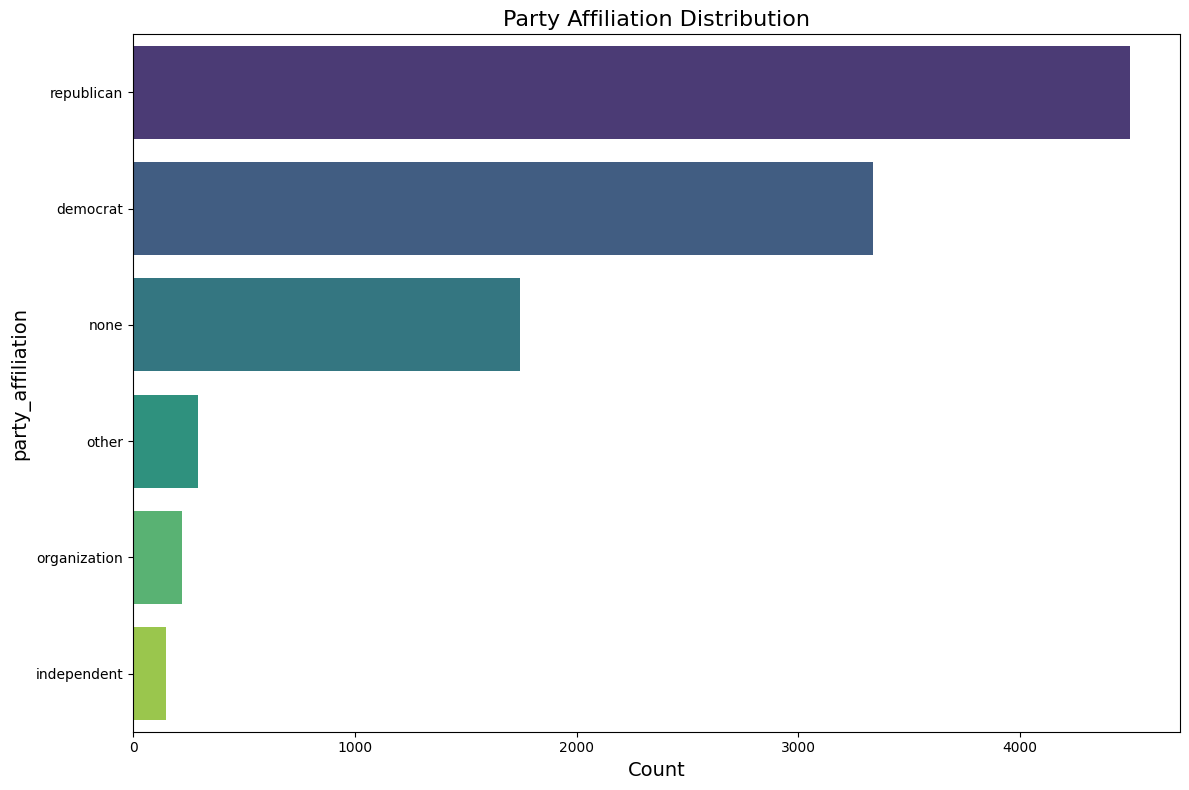

<ipython-input-23-80e15326d739>:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='count', y='category', palette="viridis")


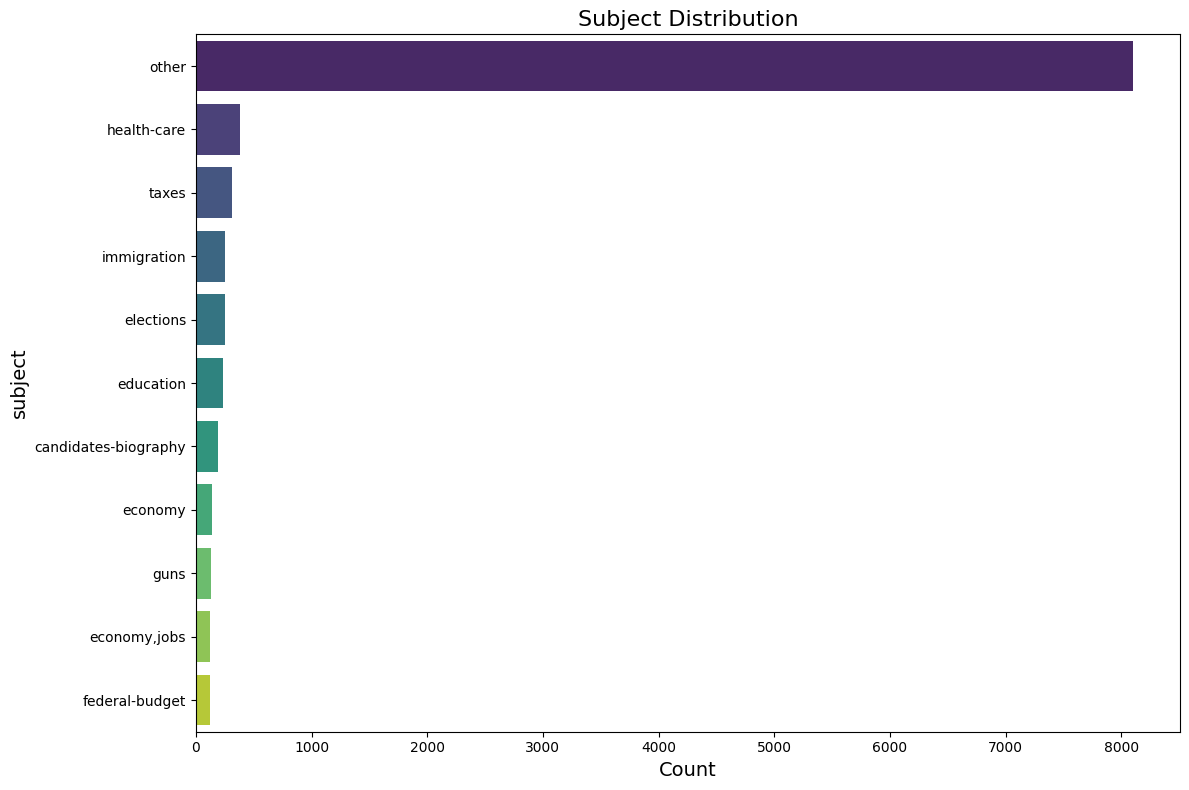

<ipython-input-23-80e15326d739>:233: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='count', y='category', palette="viridis")


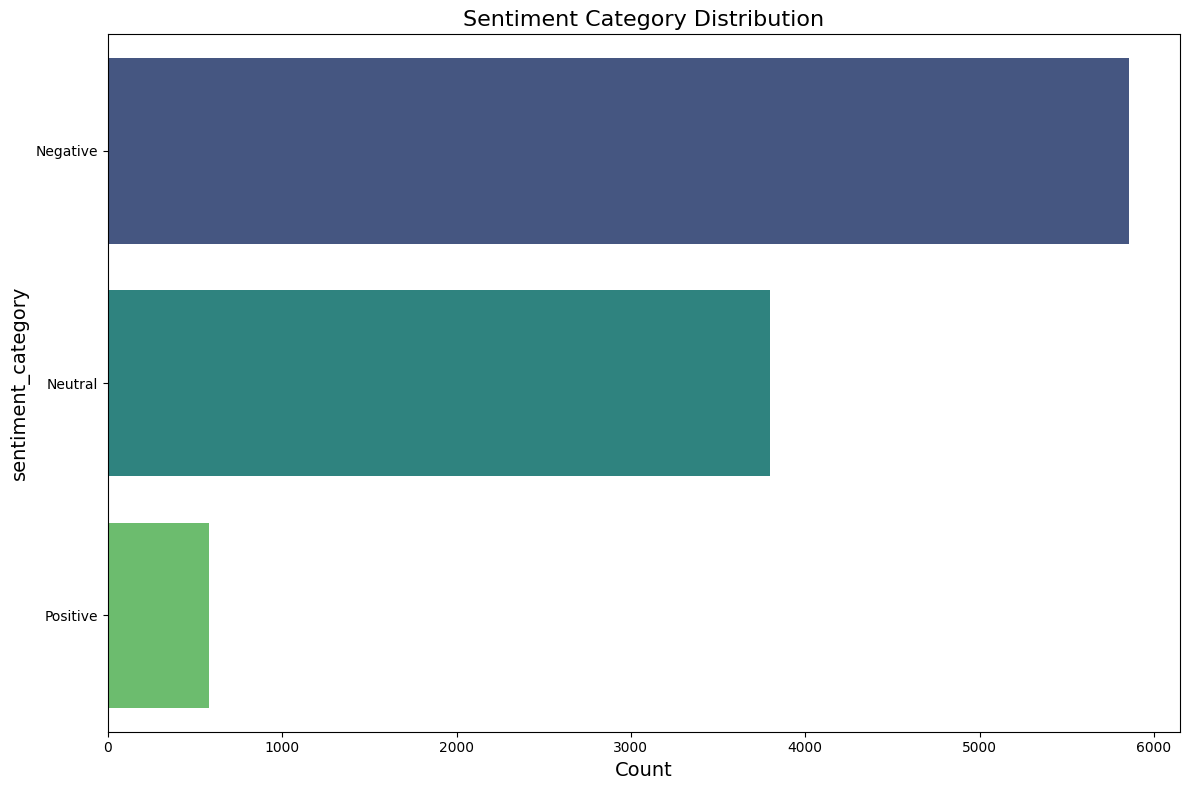

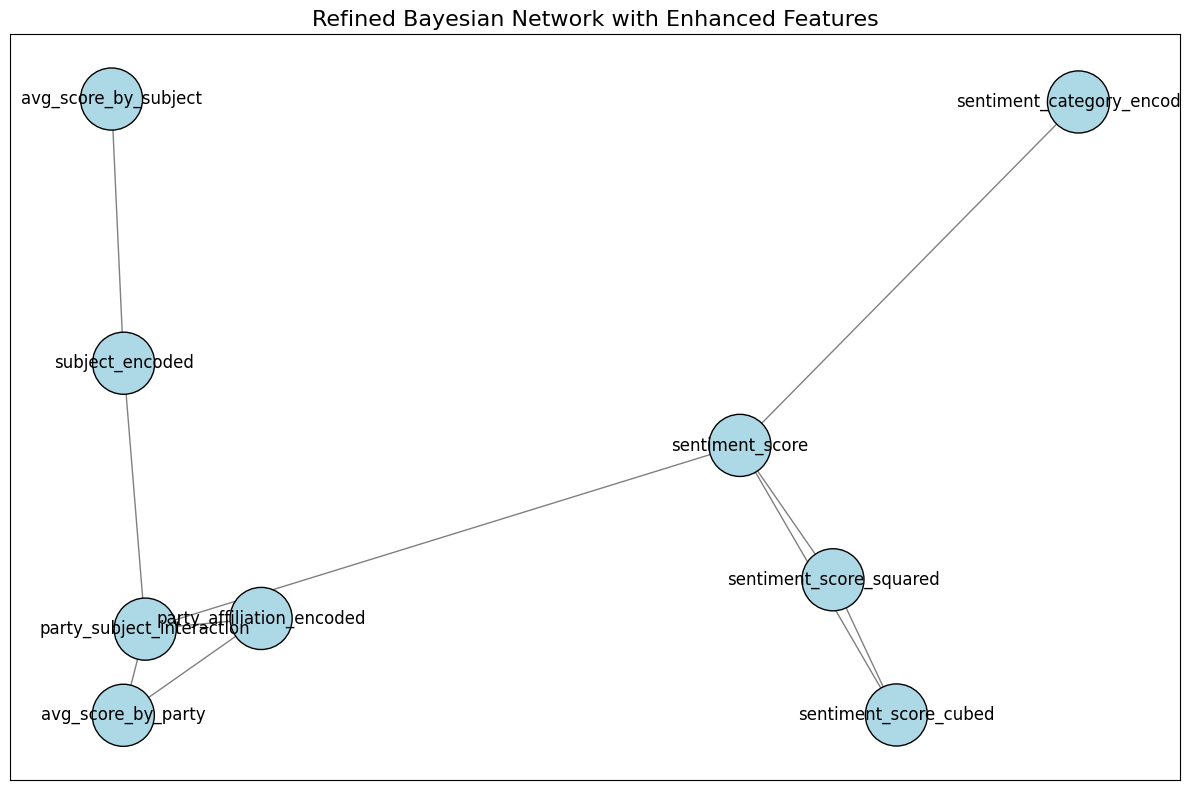

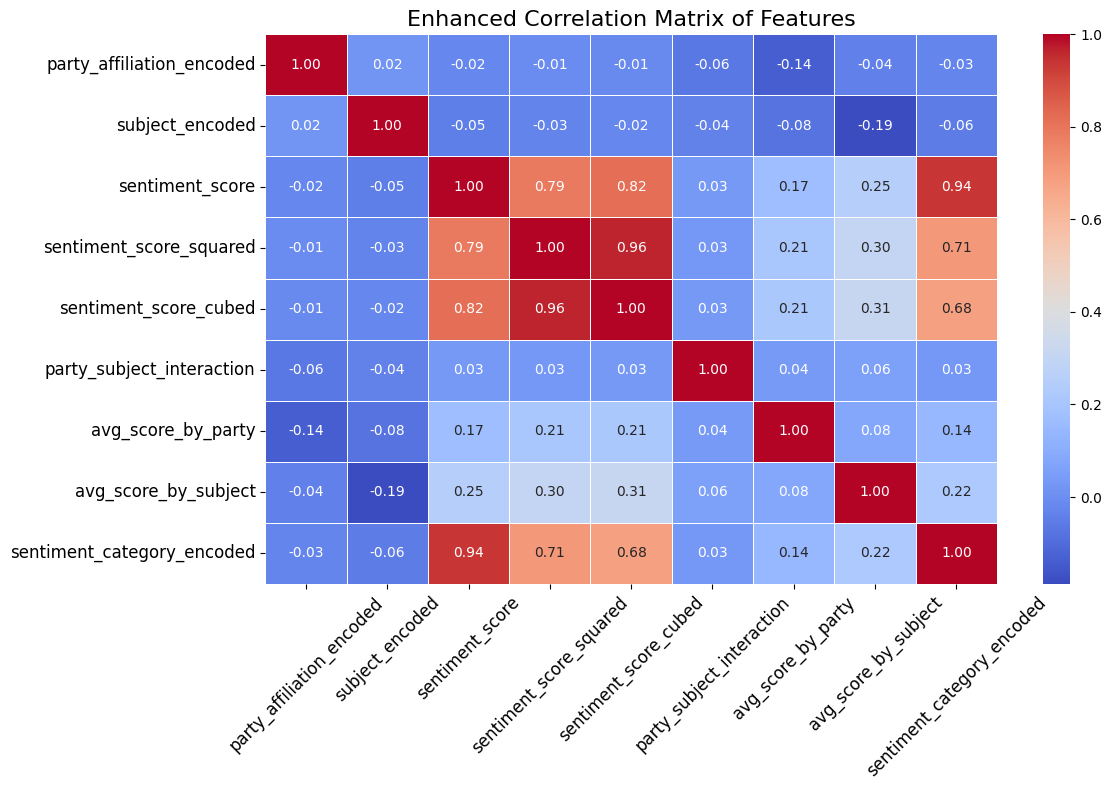

Train Processed Columns: Index(['sentiment_score', 'party_affiliation_encoded', 'subject_encoded',
       'interaction_encoded', 'party_subject_interaction',
       'sentiment_score_squared', 'sentiment_score_cubed',
       'sentiment_score_log', 'avg_score_by_party', 'avg_score_by_subject',
       ...
       'interaction_tea-party-member_government-efficiency,poverty,state-budget,taxes',
       'interaction_tea-party-member_public-safety,transportation',
       'interaction_tea-party-member_state-budget,taxes,transportation',
       'interaction_tea-party-member_taxes',
       'interaction_tea-party-member_taxes,transportation',
       'interaction_tea-party-member_transportation',
       'sentiment_category_Negative', 'sentiment_category_Neutral',
       'sentiment_category_Positive', 'sentiment_category_encoded'],
      dtype='object', length=4987)
Test Processed Columns: Index(['party_affiliation', 'subject', 'interaction', 'sentiment_category',
       'sentiment_score', 'party_aff

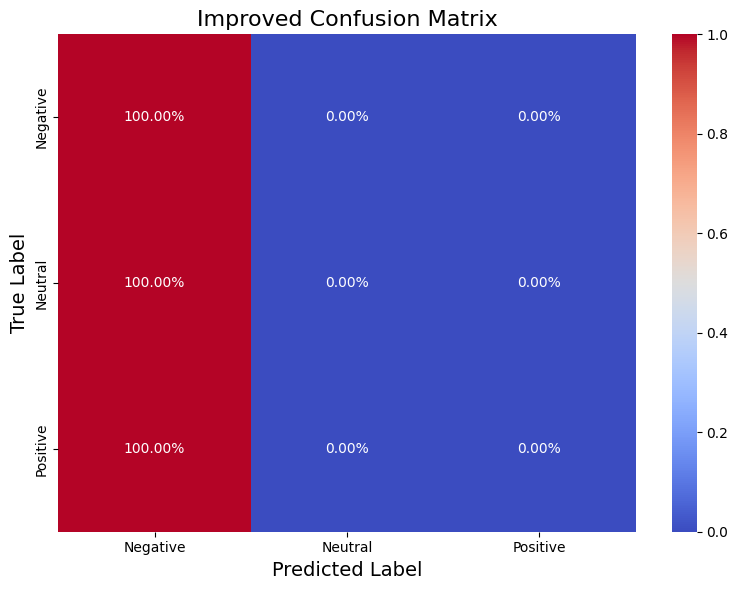

In [23]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from collections import defaultdict, Counter
import networkx as nx
import seaborn as sns
import pandas as pd
import heapq
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Step 1: Load CSV Data
def load_csv(file_path):
    """
    Load data from a CSV file into a list of dictionaries.
    """
    data = []
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append(row)
    return data


# Step 2: Preprocess Data

def preprocess_data_optimized(data):
    processed_data = []
    for row in data:
        if not all([row.get('party_affiliation'), row.get('sentiment_score'), row.get('subject')]):
            continue
        try:
            sentiment_score = float(row['sentiment_score'])
            sentiment = "Negative" if sentiment_score < -0.3 else "Positive" if sentiment_score > 0.3 else "Neutral"
        except ValueError:
            continue

        party_affiliation = row['party_affiliation'].strip().lower()
        subject = row['subject'].strip().lower()
        interaction = f"{party_affiliation}_{subject}"

        processed_data.append({
            'party_affiliation': party_affiliation,
            'subject': subject,
            'interaction': interaction,
            'sentiment_category': sentiment,
            'sentiment_score': sentiment_score
        })

    df = pd.DataFrame(processed_data)

    # Handle rare categories dynamically
    min_threshold = max(5, int(0.01 * len(df)))  # Threshold as 1% of the data or 5, whichever is higher
    df['party_affiliation'] = df['party_affiliation'].where(
        df['party_affiliation'].map(df['party_affiliation'].value_counts()) > min_threshold, 'other'
    )
    df['subject'] = df['subject'].where(
        df['subject'].map(df['subject'].value_counts()) > min_threshold, 'other'
    )

    # Standardize numerical features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df['sentiment_score'] = scaler.fit_transform(df[['sentiment_score']])

    # Encode categorical features
    label_encoder = LabelEncoder()
    for col in ['party_affiliation', 'subject', 'interaction', 'sentiment_category']:
        df[f"{col}_encoded"] = label_encoder.fit_transform(df[col])

    return df



def enhanced_feature_engineering(df):
    # Interaction terms
    df['party_subject_interaction'] = df['party_affiliation_encoded'] * df['subject_encoded']

    # Polynomial transformations
    df['sentiment_score_squared'] = df['sentiment_score'] ** 2
    df['sentiment_score_cubed'] = df['sentiment_score'] ** 3

    # Log transformations for smoother distributions
    df['sentiment_score_log'] = np.log1p(np.abs(df['sentiment_score']))

    # Weighted sentiment scores by party and subject
    df['avg_score_by_party'] = df.groupby('party_affiliation_encoded')['sentiment_score'].transform('mean')
    df['avg_score_by_subject'] = df.groupby('subject_encoded')['sentiment_score'].transform('mean')

    # Bin numerical features
    df['sentiment_score_bin'] = pd.cut(df['sentiment_score'], bins=5, labels=False)

    # Fill NaNs caused by group operations
    df.fillna(0, inplace=True)

    return df

def advanced_balance_dataset(df, target_col):
    """
    Balance the dataset using SMOTE, ensuring categorical data is encoded correctly.
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns
    numerical_cols = X.select_dtypes(exclude=['category', 'object']).columns

    # Apply preprocessing (fit and transform)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)  # One-hot encode categorical features
        ]
    )

    # Fit and transform the data
    X_encoded = preprocessor.fit_transform(X)

    # Apply SMOTE to oversample minority classes
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_encoded, y)

    # Convert back to DataFrame for easier manipulation
    feature_names = numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    X_smote = pd.DataFrame(X_smote, columns=feature_names)
    y_smote = pd.Series(y_smote, name=target_col)

    # Combine features and target into a balanced DataFrame
    balanced_df = pd.concat([X_smote, y_smote], axis=1)
    return balanced_df

    # Fit and transform the data
    X_encoded = preprocessor.fit_transform(X)

    # Apply SMOTE to oversample minority classes
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_encoded, y)

    # Convert back to DataFrame for easier manipulation
    feature_names = numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    X_smote = pd.DataFrame(X_smote, columns=feature_names)
    y_smote = pd.Series(y_smote, name=target_col)

    # Combine features and target into a balanced DataFrame
    balanced_df = pd.concat([X_smote, y_smote], axis=1)
    return balanced_df


    # Fit and transform the data
    X_encoded = preprocessor.fit_transform(X)

    # Apply SMOTE to oversample minority classes
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_encoded, y)

    # Convert back to DataFrame for easier manipulation
    feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    X_smote = pd.DataFrame(X_smote, columns=feature_names)
    y_smote = pd.Series(y_smote, name=target_col)

    # Combine features and target into a balanced DataFrame
    balanced_df = pd.concat([X_smote, y_smote], axis=1)
    return balanced_df


    # Transform the data
    X_encoded = preprocessor.fit_transform(X)

    # Get feature names for the transformed data
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    all_feature_names = numerical_cols + cat_feature_names.tolist()

    # Apply SMOTE to oversample minority classes
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_encoded, y)

    # Combine the resampled data into a DataFrame
    X_smote = pd.DataFrame(X_smote, columns=all_feature_names)
    y_smote = pd.Series(y_smote, name=target_col)

    # Return the balanced DataFrame
    balanced_df = pd.concat([X_smote, y_smote], axis=1)
    return balanced_df

# Advanced Balancing with SMOTE


# Improved Handling of Unprocessed Rows
def handle_unprocessed_rows(row, train_processed, label_encoder):
    if row['party_affiliation_encoded'] not in train_processed['party_affiliation_encoded'].unique() or \
       row['subject_encoded'] not in train_processed['subject_encoded'].unique():
        # Use group-specific mode
        group_mode = train_processed.groupby(['party_affiliation_encoded', 'subject_encoded'])['sentiment_category_encoded'].agg(lambda x: x.mode()[0])
        if (row['party_affiliation_encoded'], row['subject_encoded']) in group_mode.index:
            return group_mode[(row['party_affiliation_encoded'], row['subject_encoded'])]
        # Fallback to dataset mode
        return train_processed['sentiment_category_encoded'].mode()[0]
    return None




# Step 3: Visualize Data Distributions
def visualize_data_distribution(data, column, title, top_n=20, min_threshold=10):
    """
    Visualize the distribution of a specific column in the dataset.
    Supports DataFrame input directly.
    """
    if isinstance(data, pd.DataFrame):  # Check if input is a DataFrame
        counts = data[column].value_counts()
    else:
        counts = Counter(row[column] for row in data)  # Support for list of dictionaries

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(counts.items(), columns=[column, 'count'])

    # Filter categories based on minimum threshold
    df['category'] = df[column].where(df['count'] >= min_threshold, 'Other')
    grouped = df.groupby('category')['count'].sum().reset_index()

    # Sort by count and select top N categories
    grouped = grouped.sort_values(by='count', ascending=False).head(top_n)

    # Plot as horizontal bar chart for better label visibility
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped, x='count', y='category', palette="viridis")
    plt.title(title, fontsize=16)
    plt.xlabel("Count", fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.tight_layout()
    plt.show()

# Step 4: Calculate Mutual Information


def calculate_normalized_mutual_information(df, feature_1, feature_2):
    """
    Calculate normalized mutual information between two features.
    """
    contingency_table = pd.crosstab(df[feature_1], df[feature_2])
    joint_prob = contingency_table / contingency_table.sum().sum()
    row_marginals = joint_prob.sum(axis=1).values
    col_marginals = joint_prob.sum(axis=0).values

    joint_entropy = -np.sum(joint_prob.values * np.log2(joint_prob.values + 1e-9))
    row_entropy = entropy(row_marginals, base=2)
    col_entropy = entropy(col_marginals, base=2)

    mi = row_entropy + col_entropy - joint_entropy
    nmi = mi / max(row_entropy, col_entropy)  # Normalize by the max entropy
    return nmi




def chow_liu_tree_optimized(data, features, target, min_connections=4):
    """
    Optimized Bayesian Network construction using precomputed MI and efficient graph operations.
    Ensures compatibility with DataFrame input.
    """
    # Ensure input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    G = nx.Graph()

    # Precompute mutual information for all pairs of features and target
    mi_matrix = {}
    for i, feature_1 in enumerate(features):
        for feature_2 in features[i + 1:]:
           mi_matrix[(feature_1, feature_2)] = calculate_normalized_mutual_information(data, feature_1, feature_2)

    for feature in features:
        mi_matrix[(feature, target)] = calculate_normalized_mutual_information(data, feature, target)

    # Add edges to the graph with precomputed mutual information
    for (u, v), weight in mi_matrix.items():
        G.add_edge(u, v, weight=weight)

    # Get the maximum spanning tree
    mst = nx.maximum_spanning_tree(G)

    # Convert MST to a directed tree
    directed_tree = nx.DiGraph()
    directed_tree.add_node(target)
    for edge in mst.edges:
        directed_tree.add_edge(edge[0], edge[1])

    # If additional connections are needed, use a priority queue
    if len(directed_tree.edges) < min_connections:
        sorted_edges = [(-weight['weight'], u, v) for u, v, weight in G.edges(data=True)]
        heapq.heapify(sorted_edges)

        while len(directed_tree.edges) < min_connections and sorted_edges:
            _, u, v = heapq.heappop(sorted_edges)
            if not directed_tree.has_edge(u, v) and not directed_tree.has_edge(v, u):
                directed_tree.add_edge(u, v)

    return directed_tree


# Step 7: Bayesian Network Visualization
def visualize_structure(bn, title="Bayesian Network"):
    G = nx.DiGraph(bn.structure)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    node_colors = ['lightblue' if node != 'sentiment_category' else 'salmon' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True) if 'weight' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()



# Step 6: Bayesian Network
class BayesianNetwork:
    def __init__(self, structure):
        self.structure = structure
        self.probabilities = {}

    def set_probabilities(self, node, cpd):
        self.probabilities[node] = cpd

    def visualize_structure(self, title="Bayesian Network"):
        G = nx.DiGraph(self.structure)
        pos = nx.spring_layout(G)
        plt.figure(figsize=(12, 8))
        nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=12)
        plt.title(title, fontsize=16)
        plt.show()

def visualize_enhanced_structure(bn, title="Enhanced Bayesian Network"):
    """
    Visualize a Bayesian Network with better layout and edge weights.
    """
    G = nx.DiGraph(bn.structure)
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))
    node_colors = ['lightblue' if node != 'sentiment_category' else 'salmon' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

    # Add edge weights to the visualization
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True) if 'weight' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def refine_bayesian_network(tree, features, target, data, max_connections=12):
    """
    Add edges with the highest mutual information while respecting connection limits.
    """
    edges = list(tree.edges)
    while len(edges) < max_connections:
        potential_edges = [
            (f1, f2) for f1 in features for f2 in features if f1 != f2 and (f1, f2) not in edges and (f2, f1) not in edges
        ]
        if not potential_edges:
            break
        new_edge = max(potential_edges, key=lambda x: calculate_normalized_mutual_information(data, x[0], x[1]))
        tree.add_edge(*new_edge)
        edges.append(new_edge)
    return tree


# Step 7: CPD Calculation
def calculate_prior(data, variable):
    counts = Counter(row[variable] for row in data)
    total = len(data)
    return {k: v / total for k, v in counts.items()}

def calculate_conditional(data, variable, given):
    joint_counts = defaultdict(lambda: defaultdict(int))
    given_counts = Counter(row[given] for row in data)

    for row in data:
        joint_counts[row[given]][row[variable]] += 1

    cond_prob = {}
    for g_val, nested in joint_counts.items():
        total_given = given_counts[g_val]
        cond_prob[g_val] = {k: v / total_given for k, v in nested.items()}
    return cond_prob

# Step 8: Inference
def query_network(bn, query, evidence):
    def get_probability(node, value, evidence):
        if node in evidence:
            return 1 if evidence[node] == value else 0
        prob = bn.probabilities.get(node, {})
        return prob.get(value, 0)

    probabilities = {val: get_probability(query, val, evidence) for val in bn.probabilities.get(query, {})}
    total = sum(probabilities.values())
    return {k: v / total for k, v in probabilities.items()} if total > 0 else {}

def predict_sentiment(bn, row, label_encoder):
    evidence = {'party_affiliation_encoded': row['party_affiliation_encoded'], 'subject_encoded': row['subject_encoded']}
    prediction = query_network(bn, 'sentiment_category_encoded', evidence)

    if prediction:
        max_confidence = max(prediction.values())
        if max_confidence < 0.4:  # Lower confidence threshold
            return train_processed['sentiment_category_encoded'].mode()[0]  # Fallback to the most common class
        predicted_sentiment = max(prediction, key=prediction.get)
        return predicted_sentiment
    return train_processed['sentiment_category_encoded'].mode()[0]



def plot_correlation_matrix(data, features, title="Correlation Matrix"):
    """
    Calculate and plot the correlation matrix for numerical features.
    """
    # Create a DataFrame for easier correlation calculation
    df = pd.DataFrame(data)

    # Convert categorical features into numeric if needed
    for feature in features:
        if df[feature].dtype == 'object':
            df[feature] = pd.factorize(df[feature])[0]

    # Compute the correlation matrix
    corr_matrix = df[features].corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return corr_matrix





# Step 9: Confusion Matrix and Metrics
# Step 9: Confusion Matrix and Metrics
def plot_confusion_matrix_and_metrics(true_labels, predicted_labels, classes, title="Confusion Matrix"):
    if not true_labels or not predicted_labels:
        print("Error: True or predicted labels are empty.")
        return

    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm.astype('float') / np.where(cm_sum == 0, 1, cm_sum)

    plt.figure(figsize=(8, 6))
    # Fix: Convert classes to a list of strings
    class_labels = label_encoder.classes_.tolist()
    sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="coolwarm", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.tight_layout()

    precision = precision_score(true_labels, predicted_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average="weighted", zero_division=0)
    accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    plt.show()

def plot_feature_importance(features, target, data):
    feature_importance = {f: calculate_normalized_mutual_information(data, f, target) for f in features}
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features])
    plt.title("Feature Importance Based on Mutual Information")
    plt.xlabel("Normalized Mutual Information")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


# Main Execution
train_file = "/content/train_final.csv"
test_file = "/content/test_final.csv"

# Step 1: Load Data
train_data = load_csv(train_file)
test_data = load_csv(test_file)

# Step 2: Preprocess Data
train_processed = preprocess_data_optimized(train_data)
test_processed = preprocess_data_optimized(test_data)

# Step 3: Enhanced Feature Engineering
train_processed = enhanced_feature_engineering(train_processed)
test_processed = enhanced_feature_engineering(test_processed)

# Visualize data distribution

visualize_data_distribution(train_processed, 'party_affiliation', "Party Affiliation Distribution")
visualize_data_distribution(train_processed, 'subject', "Subject Distribution")
visualize_data_distribution(train_processed, 'sentiment_category', "Sentiment Category Distribution")

# Build Bayesian Network
# Ensure all columns have no NaN values
for column in train_processed.columns:
    if train_processed[column].isnull().sum() > 0:
        if train_processed[column].dtype.name == 'category':
            if "Unknown" not in train_processed[column].cat.categories:
                train_processed[column] = train_processed[column].cat.add_categories(["Unknown"])
            train_processed[column] = train_processed[column].fillna("Unknown")
        else:
            train_processed[column] = train_processed[column].fillna(0)

# Balance the dataset
train_balanced = advanced_balance_dataset(train_processed, 'sentiment_category_encoded')




# Step 4: Apply Enhanced Feature Engineering
train_processed = enhanced_feature_engineering(train_balanced)
test_processed = enhanced_feature_engineering(test_processed)

# Step 5: Build Bayesian Network
features = [
    'party_affiliation_encoded', 'subject_encoded', 'sentiment_score',
    'sentiment_score_squared', 'sentiment_score_cubed', 'party_subject_interaction',
    'avg_score_by_party', 'avg_score_by_subject'
]
target = 'sentiment_category_encoded'

# Construct the Bayesian Network structure
structure = chow_liu_tree_optimized(train_processed, features, target, min_connections=6)
structure = refine_bayesian_network(structure, features, target, max_connections=10, data=train_processed)

# Visualize the Bayesian Network structure
bn = BayesianNetwork(structure)
visualize_enhanced_structure(bn, title="Refined Bayesian Network with Enhanced Features")

# Step 6: Plot the Correlation Matrix
plot_correlation_matrix(
    train_processed,
    features + [target],
    title="Enhanced Correlation Matrix of Features"
)

# Step 7: Prediction and Evaluation

all_sentiment_categories = ['Positive', 'Negative', 'Neutral']
label_encoder = LabelEncoder()
label_encoder.fit(all_sentiment_categories)

true_labels = []
predicted_labels = []
unprocessed_rows = []  # Track rows with missing or unseen features

for row in test_processed.to_dict(orient='records'):
    true_labels.append(row['sentiment_category_encoded'])  # Add the true label

    # Handle unseen or missing features
    imputed_label = handle_unprocessed_rows(row, train_processed, label_encoder)
    if imputed_label is not None:
        predicted_labels.append(imputed_label)
    else:
        predicted_labels.append(predict_sentiment(bn, row, label_encoder))
print("Train Processed Columns:", train_processed.columns)
print("Test Processed Columns:", test_processed.columns)
  # Track rows with missing or unseen features



# Debugging Information
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of predicted_labels: {len(predicted_labels)}")
if unprocessed_rows:
    print(f"Number of unprocessed rows: {len(unprocessed_rows)}")
    print("Sample unprocessed rows:", unprocessed_rows[:5])

# Step 8: Evaluate and Visualize Results
classes = list(range(len(label_encoder.classes_)))  # Classes are encoded integers
plot_confusion_matrix_and_metrics(true_labels, predicted_labels, classes, title="Improved Confusion Matrix")